ResNet18 model 

In [53]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 

from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet18


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()

In [54]:
device

device(type='cuda')

In [55]:
import art
from art import attacks 
from art.attacks.evasion import DeepFool, CarliniL0Method, BasicIterativeMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier

In [56]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [57]:
# defining hyperparameters  
epochs = 30
#epochs = 31   #the nn will train 31 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [58]:
learning_rate = 0.0001 #how much the weight will be updated each time \
batch_size = 23

In [59]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [60]:
valid_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [61]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    global base_dataset 
    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset, train_dataset
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    # global valid_loader 
    # valid_loader = torch.utils.data.DataLoader(
    #     val_dataset, batch_size=batch_size,
    #     num_workers=num_workers, 
    #     #sampler = valid_sampler
    # )

    return train_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


In [62]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [63]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [64]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [65]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [66]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
                  

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [67]:
model = resnet18(pretrained = False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 43)
model = model.to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 45.15 MiB already allocated; 14.06 MiB free; 66.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [68]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 45.15 MiB already allocated; 14.06 MiB free; 66.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(model.state_dict(), "resnet18.pt")

In [48]:
import torch
torch.cuda.empty_cache()

In [49]:
model.load_state_dict(torch.load("resnet18.pt"))
model.eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.76 GiB total capacity; 45.16 MiB already allocated; 14.06 MiB free; 66.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)


In [19]:
from torch.utils.data import ConcatDataset
combined_gtsrb = ConcatDataset([base_dataset, test_dataset])

In [20]:
# adversarial vs actual label

plot_output = []
iterations = 10

# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
tp = 0
tn = 0
fp = 0 
fn = 0
total_img = 0
total_14 = 0
for i in range(iterations):
    # Define an attack that only runs until this max iteration
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(combined_gtsrb):
        total_img += 1 
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is the adversarial attack successful or not?
        # How do you define a successful attack?
        # The definition below is just an example
        if true_label == 14:
                total_14 += 1
        elif true_label == 14 and adversarial_prediction == 14:
                tp += 1
        elif true_label == 14 and adversarial_prediction != 14:
                fn += 1
        elif true_label != 14 and adversarial_prediction != 14:
                tn += 1
        elif true_label != 14 and adversarial_prediction == 14:
                fp += 1

        if j > 100: 
                break
#     ASR = success_rates.count(True) / len(success_rates)
#     accuracy_score = (1-ASR) 
#     plot_output.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print(tp, tn, fp, fn)

0 1020 0 0


In [ ]:
print(total_img)

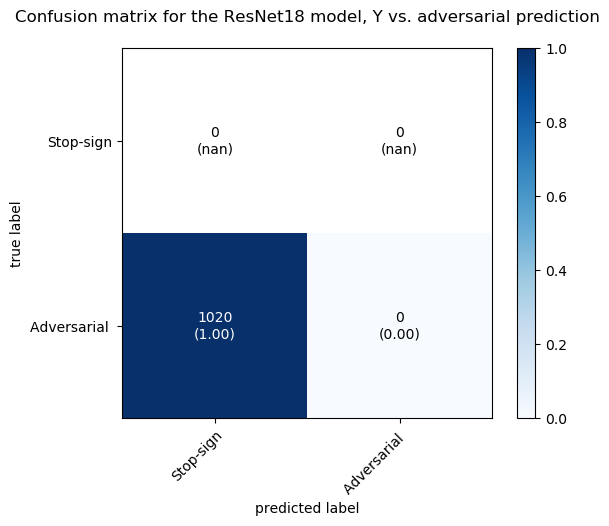

In [29]:
from mlxtend.plotting import plot_confusion_matrix
confusion_values = np.array([[0.0, 0.0],
               [1020, 0.0]])
# Classes
classes = ['Stop-sign', 'Adversarial ']

figure, ax = plot_confusion_matrix(conf_mat = confusion_values,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)
plt.title("Confusion matrix for the ResNet18 model, Y vs. adversarial prediction")
plt.show()

In [22]:
# normal prediction vs adversarial prediction

plot_output = []
iterations = 10

# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
tp = 0
tn = 0
fp = 0 
fn = 0
total_img = 0
total_14 = 0
for i in range(iterations):
    # Define an attack that only runs until this max iteration
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(combined_gtsrb):
        total_img += 1 
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is the adversarial attack successful or not?
        # How do you define a successful attack?
        # The definition below is just an example
        if normal_prediction == 14:
                total_14 += 1
        elif normal_prediction == 14 and adversarial_prediction == 14:
                tp += 1
        elif normal_prediction == 14 and adversarial_prediction != 14:
                fn += 1
        elif normal_prediction != 14 and adversarial_prediction != 14:
                tn += 1
        elif normal_prediction != 14 and adversarial_prediction == 14:
                fp += 1

        if j > 100: 
                break
#     ASR = success_rates.count(True) / len(success_rates)
#     accuracy_score = (1-ASR) 
#     plot_output.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print(tp, tn, fp, fn)

0 1020 0 0


In [ ]:
print(total_img)

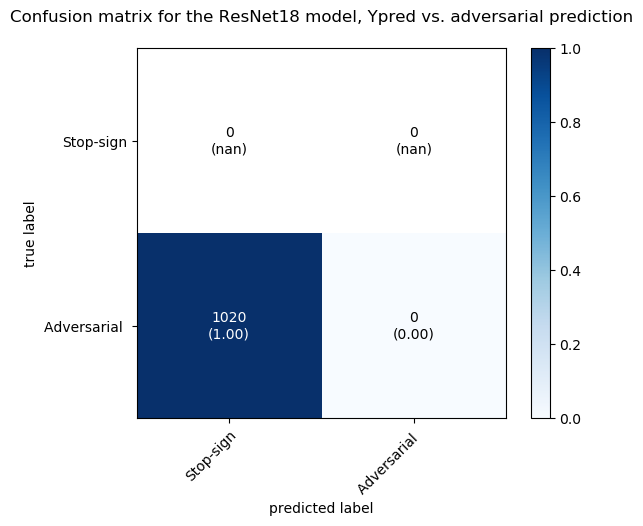

In [28]:
from mlxtend.plotting import plot_confusion_matrix
confusion_values = np.array([[0, 0],
               [1020, 0]])
# Classes
classes = ['Stop-sign', 'Adversarial ']

figure, ax = plot_confusion_matrix(conf_mat = confusion_values,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True)
plt.title("Confusion matrix for the ResNet18 model, Ypred vs. adversarial prediction")
plt.show()